# TRAPPIST-1 Simulation
## Stage I: Sequential formation & migration
### Simulation set-up
TRAPPIST-1 planet data from Huang & Ormel (2022):
<center>
<img width=500 src="./Figures/trappist1_data.png"></img>
</center>

In [465]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt

# Create the simulation
sim = rebound.Simulation()
sim.units = ('AU', 'yr', 'Msun')
sim.integrator = "whfast"
sim.random_seed = 13741154 # for reproducibility

# Add the star
sim.add(m=0.09)

# Define planet masses (converted to Msun), semi‐major axes (AU), and eccentricities
masses = np.array([1.374, 1.308, 0.388, 0.692, 1.039, 1.321, 0.326]) * 3.003e-6

# Observed a values
# a0 = np.array([1.154, 1.580, 2.227, 2.925, 3.849, 4.683, 6.189]) * 0.01  

# Figure 3 imitation
# b_a = 1.3
# a0 = np.array([b_a, b_a*2**(2/3)*1.01, b_a*2**(4/3)*1.03, b_a*2**(4/3)*1.5**(2/3)*1.07, b_a*2**(4/3)*1.5**(4/3)*1.1, b_a*2**(4/3)*1.5**(6/3)*1.13, b_a*2**(4/3)*1.5**(8/3)*1.15]) * 0.01  
# e0 = np.array([0.004, 0.002, 0.006, 0.0065, 0.009, 0.004, 0.0035])

# b/c/d Laplace resonance
masses = masses[0:3] # limit to b/c/d
a0 = np.array([1.15, 1.58, 2.23]) * 0.01
e0 = np.array([0, 0, 0])

num_planets = len(masses)


### Disk Parameters
From Huang & Ormel (2022):
<center>
<img width=400 src="./Figures/Huang_parameters.png"></img>
</center>

Depending on the model, the parameters are changed.
- In the `bC` model, $\tau_{a,\oplus}=5e3$, $C_e =0.1$, and $r_c=0.013$ (observed location of planet b).
- In the `dCcgI` model, $r_c = 0.023$ (observed location of planet d).

In [466]:
# Free parameters
tau_a_earth = 10e3
C_e = 0.1 
r_c = 0.02
A_a = 50
A_e = 1

# Other parameters
h = 0.03
M_g_dot = 10e-10
M_star = 0.09
gamma_I = 2
tau_d = 1e5
Delta = 2*h*r_c
Q_sim = 100

### Reboundx forces
We add the following forces using `REBOUNDx`:
- `type_I_migration`
- `modify_orbits_forces`
- `tides_constant_time_lag`

In [467]:
rebx = reboundx.Extras(sim)

# type I migration
# mig = rebx.load_force("type_I_migration")
# rebx.add_force(mig)

# Orbital damping
mof = rebx.load_force("modify_orbits_forces")
rebx.add_force(mof)

# Tidal damping
tides = rebx.load_force("tides_constant_time_lag")
rebx.add_force(tides)

### Type I Migration
* The disk scale height in code units (here AU), 1 code unit from the central star ($h_1$) 
* The disk surface density 1 code unit from the central star ($\Sigma_1$) 
* The disk surface density exponent ($\alpha$), assuming a power law $\Sigma(r) = \Sigma_1 r^{-\alpha}$, where $r$ is the radial distance from the star in code units
* The disk flaring index ($\beta$), assuming a power-law scale height $h(r) = h_1 r^\beta$

In [468]:
# mig.params["tIm_scale_height_1"] = 0.03
# mig.params["tIm_surface_density_1"] = 1.1e-4 # 1000 g/cm^2 surface density in Msun/AU^2
# mig.params["tIm_surface_density_exponent"] = 1
# mig.params["tIm_flaring_index"] = 0.25

### Adding an inner disk edge (ide) to halt migration
An artificial prescription for halting the planet at `ide_position` (in AU). 

We also have to set the 'width' of the ide. This is the width of the region in which the migration torque flips sign, so the planet will stop within this distance scale of the inner disk edge's location. 

Here we set the width to the scale height of the disk at the inner disk edge:

In [469]:
# mig.params["ide_position"] = 0.02
# mig.params["ide_width"] = mig.params["tIm_scale_height_1"]*mig.params["ide_position"]**mig.params["tIm_flaring_index"]
# print('Planet will stop within {0:.3f} AU of the inner disk edge at {1} AU'.format(mig.params["ide_width"], mig.params["ide_position"]))

### Orbital Damping
We calculate the semi-major axis damping timescale and eccentricity damping timescale based on these equations from Huang & Ormel (2022):
<center>
<img width=400 src="./Figures/Huang_timescales.png"></img>
</center>

Though not computed here, note that $\Omega_K = \sqrt{\dfrac{GM_{\star}}{r^3}}$ is the Keplerian angular velocity.

In [470]:
q_vals = masses / M_star
q_earth =  3.003e-6 / M_star

def f_functions(r):
    # Piecewise functions f_a and f_e
    conditions = [
        r < r_c - Delta,
        (r_c - Delta <= r) & (r < r_c),
        (r_c <= r) & (r < r_c + Delta + 1 / A_a),
        r >= r_c + Delta + 1 / A_a
    ]

    f_a = [
        0,          
        A_a * (r_c - Delta - r) / Delta,
        (r-r_c)* (A_a + 1) / (Delta + 1/A_a) - (A_a), # modified to make it continuous, paper might be wrong
        1
    ]

    f_e = [
        0,          
        A_e * (r - r_c + Delta) / Delta,
        (A_e - 1) * (r_c + Delta + 1 / A_a - r) / (Delta + 1 / A_a) + 1, 
        1
    ]

    f_a_vals = np.select(conditions, f_a, default=np.nan)
    f_e_vals = np.select(conditions, f_e, default=np.nan)
    return f_a_vals, f_e_vals

def plot_f_functions():
    A_e = 2
    A_a = 3
    r_c = 9
    Delta = 3

    # %matplotlib widget

    fig, ax = plt.subplots()
    fig.set_figwidth(4.0)
    fig.set_figheight(4.0)

    xs = np.linspace(0, 3*r_c, 100)
    f_a_vals, f_e_vals = f_functions(xs)
    ax.plot(xs, f_a_vals, label='f_a')  
    ax.plot(xs, f_e_vals, label='f_e')  
    plt.ylabel("$f_a$ or $f_e$")
    plt.xlabel("Distance from the star")
    plt.legend()
    plt.show()

# plot_f_functions()
print(r_c - Delta)


0.0188


### Tidal Damping
We want stronger damping on b, weaker on c, none on d.

In [471]:
# TODO

### Functions for Calculating Laplace Angle
We use the formula $$\lambda = M+\varpi = M+\omega + \Omega$$ where
- $\lambda$ is the mean longitude
- $M$ is the mean anomaly
- $\varpi$ is the longitude of periapsis
- $\omega$ is the argument of periapsis
- $\Omega$ is the longitude of ascending node

In [472]:
def mean_longitude(p):
    return (p.M + p.omega + p.Omega) % (2*np.pi)

def laplace_angle(sim, i, j, k):
    ps = sim.particles
    lam_i = mean_longitude(ps[i])
    lam_j = mean_longitude(ps[j])
    lam_k = mean_longitude(ps[k])

    phi = 2*lam_i - 5*lam_j + 3*lam_k
    return np.mod(phi, 2*np.pi)

### Integrate and Record Stage I
We set the timestep to 5% of the orbital period of Planet b to make sure we always resolve the orbit

In [473]:
stage_i_time_steps = 1000
stage_i_end = 5000 # yrs
stage_i_times = np.linspace(0, stage_i_end, stage_i_time_steps, endpoint=False)

a_vals = np.full((num_planets, stage_i_time_steps), np.nan)
e_vals = np.full((num_planets, stage_i_time_steps), np.nan)
n_vals = np.full((num_planets, stage_i_time_steps), np.nan)
P_vals = np.full((num_planets, stage_i_time_steps), np.nan)
P_ratios = np.full((num_planets-1, stage_i_time_steps), np.nan)
phi_vals = np.full(stage_i_time_steps, np.nan)

# Add planets 
for i in range(3): # b/c/d only
    sim.add(m=masses[i], a=a0[i], e=e0[i])

# Move to center of momentum
sim.move_to_com()
ps = sim.particles

sim.dt = ps[1].P / 20 # 5% of innermost period, 1/12 is also recommended
print(sim.dt)

0.0002055387719340592


In [474]:
# injection_schedule = {
#     30: 2,
#     60: 3,
#     90: 4,
#     120: 5,
#     150: 6
# }

for i, t in enumerate(stage_i_times):
    sim.integrate(t)
    
    # if i in injection_schedule:
    #     idx = injection_schedule[i]
    #     sim.add(m=masses[idx], a=a0[idx], e=e0[idx])
    #     sim.move_to_com()
    #     ps = sim.particles
        
    for j, p in enumerate(ps[1:]):  # skip the star
        a_vals[j, i] = p.a
        e_vals[j, i] = p.e
        n_vals[j, i] = p.n
        P_vals[j, i] = p.P
    for j, p in enumerate(ps[1:num_planets]): # num_planets-1 ratios
        P_ratios[j, i] = P_vals[j+1, i] / P_vals[j, i]
    
    phi_vals[i] = laplace_angle(sim, 1, 2, 3) # b,c,d
        
    f_a_vals, f_e_vals = f_functions(a_vals[:, i])
    for j, p in enumerate(ps[1:]): # b = 0, c = 1, etc.
        if j == 6: 
            p.params["tau_a"] = -tau_a_earth * (q_earth / q_vals[j]) / f_a_vals[j] # negative so it is damping      
            # print(f"h tau_a: {p.params['tau_a']}")    
        elif j == 5:
            p.params["tau_a"] = -tau_a_earth * (q_earth / q_vals[j]) / f_a_vals[j]
            p.params["tau_a"] *= 2 # multiply tau_a for g by 2 to prevent overaggressive plowing
            # print(f"g tau_a: {p.params['tau_a']}")    
        else:
            p.params["tau_a"] = -abs(tau_a_earth * (q_earth / q_vals[j]) / f_a_vals[j]) * 5 # multiply for nonaggression
            
        if p.params["tau_a"] == -np.inf: # not in gas disk (in r_c or too far out)
            p.params["tau_a"] = 1e32 # turns off migration

    for j, p in enumerate(ps[1:]): # skip star at index 0
        if j == 6:
            p.params["tau_e"] = -C_e * h**2 * p.params["tau_a"] * f_a_vals[j] / f_e_vals[j]
            # print(f"h tau_e: {p.params['tau_e']}")    
        elif j == 5:
            p.params["tau_e"] = -C_e * h**2 * p.params["tau_a"] * f_a_vals[j] / f_e_vals[j]
            # print(f"g tau_e: {p.params['tau_e']}")    
        else:
            pass
            # p.params["tau_e"] = -C_e * h**2 * p.params["tau_a"] * f_a_vals[j] / f_e_vals[j]

/var/folders/_j/mydjhq1179jffd525zbvkvyh0000gn/T/ipykernel_88131/1349935468.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  p.params["tau_a"] = -abs(tau_a_earth * (q_earth / q_vals[j]) / f_a_vals[j]) * 5 # multiply for nonaggression


### Save Stage I Simulation to Disk

In [475]:
# sim.save_to_file("stage_i.bin")
# sim = None # Remove reference, allow python to release memory

# # Save arrays to a .npz file
# np.savez_compressed('trappist1_stage_i.npz', arr0=a_vals, arr1=e_vals, arr2=n_vals, arr3=P_vals, arr4=P_ratios,
#                                              arr5=stage_i_time_steps, arr6=stage_i_times, arr7=stage_i_end)

## Stage II: b and c migrate into cavity

In [476]:
# # Load from Stage I
# sim = rebound.Simulation("stage_I.bin")
# loaded = np.load('trappist1_stage_i.npz')
# a_vals, e_vals, n_vals, P_vals, P_ratios = loaded['arr0'], loaded['arr1'], loaded['arr2'], loaded['arr3'], loaded['arr4']
# stage_i_time_steps, stage_i_times, stage_i_end = loaded['arr5'], loaded['arr6'], loaded['arr7']

In [477]:
# stage_ii_time_steps = 7500 
# stage_ii_end = 30000 # yrs

# stage_ii_times = np.linspace(stage_i_end, stage_ii_end, stage_ii_time_steps)
# times = np.append(stage_i_times, stage_ii_times)

# # extends the arrays for data
# nans_to_add = np.full((num_planets, stage_ii_time_steps), np.nan)

# # a_vals = np.concatenate((a_vals, nans_to_add), axis=1) # axis 1 for horizontal concat
# e_vals = np.concatenate((e_vals, nans_to_add), axis=1)
# n_vals = np.concatenate((n_vals, nans_to_add), axis=1)
# P_vals = np.concatenate((P_vals, nans_to_add), axis=1)

# nans_to_add = np.full((num_planets-1, stage_ii_time_steps), np.nan)
# P_ratios = np.concatenate((P_ratios, nans_to_add), axis=1) # axis 1 for horizontal concat

### Integrate and Record Stage II

In [478]:
# for i, t in enumerate(stage_ii_times, start=stage_i_time_steps):
#     sim.integrate(t)
        
#     for j, p in enumerate(ps[1:]):  # skip the star
#         a_vals[j, i] = p.a
#         e_vals[j, i] = p.e
#         n_vals[j, i] = np.sqrt(sim.G * ps[0].m / p.a**3) 
#         P_vals[j, i] = 2 * np.pi / n_vals[j, i]
#     for j, p in enumerate(ps[1:7]):  # first 6 planet pairs
#         P_ratios[j, i] = P_vals[j+1, i] / P_vals[j, i]
        
#     f_a_vals, f_e_vals = f_functions(a_vals[:, i])
#     for j, p in enumerate(ps[1:]):
#         if j == 6: # Planet h
#             p.params["tau_a"] = -tau_a_earth * (q_earth / q_vals[j]) / f_a_vals[j] # negative so it is damping      
#             # print(f"h tau_a: {p.params['tau_a']}")    
#         elif j == 5: # Planet g
#             p.params["tau_a"] = -tau_a_earth * (q_earth / q_vals[j]) / f_a_vals[j]
            
#             p.params["tau_a"] *= 2 # divide tau_a for g by 2 to prevent overaggressive plowing
#             # print(f"g tau_a: {p.params['tau_a']}")    
        
#         elif j == 1: # Planet c
#             p.params["tau_a"] = -tau_a_earth * (q_earth / q_vals[j]) / f_a_vals[j]
#             p.params["tau_a"] *= -15 # to make it negative and gentle
#             # print(f"c tau_a: {p.params['tau_a']}")    
#         else:
#             p.params["tau_a"] = 1e32 # turns off migration
            
#         if p.params["tau_a"] == -np.inf:
#             p.params["tau_a"] = 1e32 # turns off migration

#     for j, p in enumerate(ps[1:]): # skip star at index 0
#         if j == 6: # Planet h
#             p.params["tau_e"] = -C_e * h**2 * p.params["tau_a"] * f_a_vals[j] / f_e_vals[j]
#             # print(f"h tau_e: {p.params['tau_e']}")    
#         elif j == 5: # Planet g
#             p.params["tau_e"] = -C_e * h**2 * p.params["tau_a"] * f_a_vals[j] / f_e_vals[j]
#             # print(f"g tau_e: {p.params['tau_e']}")    
#         p.params["tau_e"] = -100 

## Stage III: Long Term Tidal Dissipation

### Changing parameters
We change $Q_{sim}=0.1$ to accelerate the sim by $10^3$ times. 

The disk torque term is ignored.

Disk repulsion

Sims that apply tidal torques on b only or b and c only are consistent with on all planets

In [479]:
# Q_sim = 0.1

# stage_iii_time_steps = 5000 
# stage_iii_end = 30000 # yrs
# stage_iii_times = np.linspace(stage_ii_end, stage_iii_end, stage_iii_time_steps)
# times = np.append(times, stage_iii_times)

# # extends the arrays for data
# nans_to_add = np.full((num_planets, stage_iii_time_steps), np.nan)

# a_vals = np.concatenate((a_vals, nans_to_add), axis=1) # axis 1 for horizontal concat
# e_vals = np.concatenate((e_vals, nans_to_add), axis=1)
# n_vals = np.concatenate((n_vals, nans_to_add), axis=1)
# P_vals = np.concatenate((P_vals, nans_to_add), axis=1)

# nans_to_add = np.full((num_planets-1, stage_iii_time_steps), np.nan)
# P_ratios = np.concatenate((P_ratios, nans_to_add), axis=1) # axis 1 for horizontal concat

In [480]:
# for i, t in enumerate(stage_iii_times, start=stage_ii_time_steps):
#     sim.integrate(t)
        
#     for j, p in enumerate(ps[1:]):  # skip the star
#         a_vals[j, i] = p.a
#         e_vals[j, i] = p.e
#         n_vals[j, i] = np.sqrt(sim.G * ps[0].m / p.a**3) 
#         P_vals[j, i] = 2 * np.pi / n_vals[j, i]
#     for j, p in enumerate(ps[1:7]):  # first 6 planet pairs
#         P_ratios[j, i] = P_vals[j+1, i] / P_vals[j, i]
        
#     f_a_vals, f_e_vals = f_functions(a_vals[:, i])
#     for j, p in enumerate(ps[1:]):
#         if j == 6: # Planet h
#             p.params["tau_a"] = -tau_a_earth * (q_earth / q_vals[j]) / f_a_vals[j] # negative so it is damping      
#             # print(f"h tau_a: {p.params['tau_a']}")    
#         elif j == 5: # Planet g
#             p.params["tau_a"] = -tau_a_earth * (q_earth / q_vals[j]) / f_a_vals[j]
            
#             p.params["tau_a"] *= 2 # divide tau_a for g by 2 to prevent overaggressive plowing
#             # print(f"g tau_a: {p.params['tau_a']}")    
        
#         elif j == 2: # Planet c
#             p.params["tau_a"] = -tau_a_earth * (q_earth / q_vals[j]) / f_a_vals[j]
#             p.params["tau_a"] *= -15 # to make it negative and gentle
#             # print(f"c tau_a: {p.params['tau_a']}")    
#         else:
#             p.params["tau_a"] = 1e32 # turns off migration
            
#         if p.params["tau_a"] == -np.inf:
#             p.params["tau_a"] = 1e32 # turns off migration

#     for j, p in enumerate(ps[1:]): # skip star at index 0
#         if j == 6: # Planet h
#             p.params["tau_e"] = -C_e * h**2 * p.params["tau_a"] * f_a_vals[j] / f_e_vals[j]
#             # print(f"h tau_e: {p.params['tau_e']}")    
#         elif j == 5: # Planet g
#             p.params["tau_e"] = -C_e * h**2 * p.params["tau_a"] * f_a_vals[j] / f_e_vals[j]
#             # print(f"g tau_e: {p.params['tau_e']}")    
#         p.params["tau_e"] = -100 

## Plotting semi-major axis and eccentricity evolution

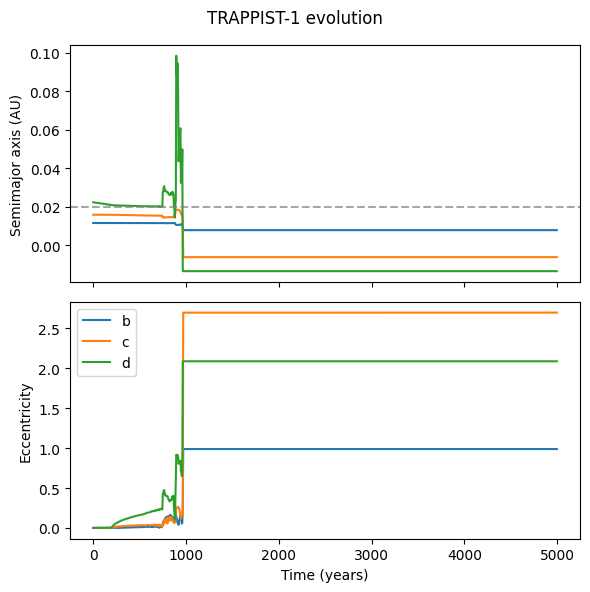

In [481]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.set_figwidth(6.0)
fig.set_figheight(6.0)

for j in range(len(masses)):
    # could also try plotting log
    ax1.plot(stage_i_times, a_vals[j], label=f'{chr(98+j)}')  # b, c, d, ...
    ax2.plot(stage_i_times, e_vals[j], label=f'{chr(98+j)}')  
plt.xlabel("Time (years)")
ax1.set_ylabel("Semimajor axis (AU)")
ax2.set_ylabel("Eccentricity")
# ax1.set_ylim(0.005, 0.13)
# ax2.set_ylim(-0.01, 0.2)

# Plot truncation radius 
ax1.axhline(r_c, color='gray', ls='--', alpha=0.7)

# # Stage indicators
# for stage in [stage_i_end, stage_ii_end, stage_iii_end]:
#     ax1.axvline(stage, color='gray', ls='--', alpha=0.7)
#     ax2.axvline(stage, color='gray', ls='--', alpha=0.7)

fig.subplots_adjust(hspace=0)

plt.suptitle("TRAPPIST-1 evolution")
plt.legend()
plt.tight_layout()
plt.show()

### Resonance Ratios

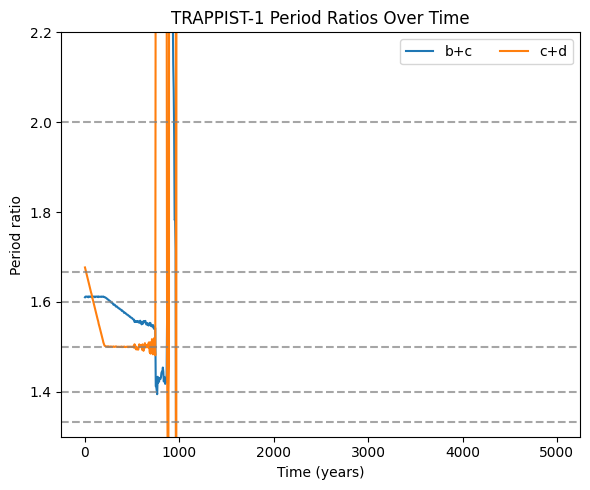

In [482]:
plt.figure(figsize=(6,5))
labels = [f"{chr(98+j-1)}+{chr(98+j)}" for j in range(1, num_planets)]  # b,c,d,...
for j in range(num_planets-1):
    plt.plot(stage_i_times, P_ratios[j], label=labels[j])

# Add horizontal lines for nearby resonances
resonances = [2, 8/5, 7/5, 5/3, 3/2, 4/3]
for r in resonances:
    plt.axhline(r, color='gray', ls='--', alpha=0.7)

# # Stage indicators
# for stage in [stage_i_end, stage_ii_end, stage_iii_end]:
#     plt.axvline(stage, color='gray', ls='--', alpha=0.7)

plt.xlabel("Time (years)")
plt.ylabel("Period ratio")
plt.ylim(1.3, 2.2)
plt.title("TRAPPIST-1 Period Ratios Over Time")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()


### Laplace Angles

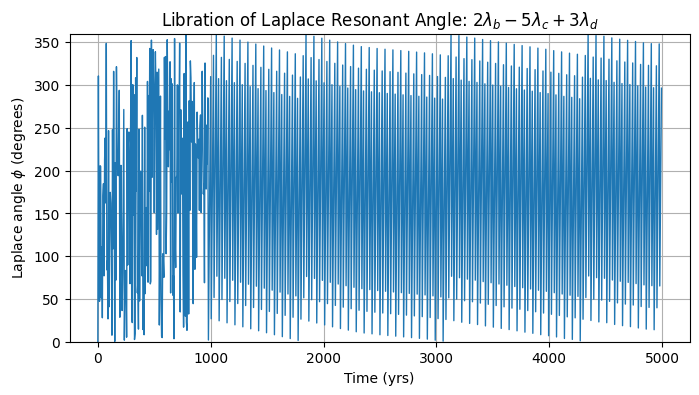

In [483]:
plt.figure(figsize=(8,4))
plt.plot(stage_i_times, np.rad2deg(phi_vals), lw=1)
plt.xlabel("Time (yrs)")
plt.ylabel("Laplace angle $\phi$ (degrees)")
plt.title("Libration of Laplace Resonant Angle: $2\lambda_b - 5\lambda_c + 3\lambda_d$")
plt.ylim(0,360)
plt.grid(True)
plt.show()

### 3BR Angles

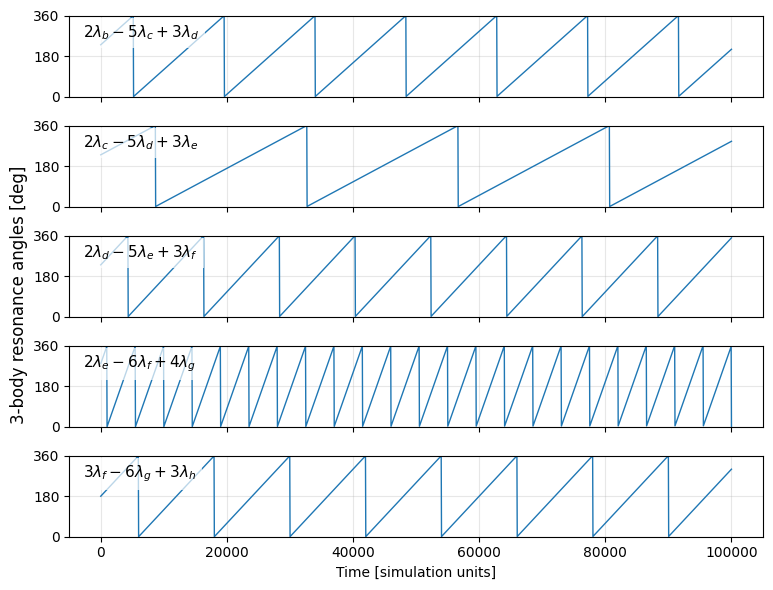

In [484]:
# Example: assume you have arrays of mean longitudes (lambda)
# for planets b, c, d, e, f, g, h over time.
# Replace these with your simulation data.
time = np.linspace(0, 1e5, 2000)  # simulation time, e.g. in years
lambda_b = (0.02 * time) % 360
lambda_c = (0.03 * time + 50) % 360
lambda_d = (0.045 * time + 100) % 360
lambda_e = (0.06 * time + 150) % 360
lambda_f = (0.08 * time + 200) % 360
lambda_g = (0.11 * time + 250) % 360
lambda_h = (0.15 * time + 300) % 360

# Define the 3-body resonance angles
phi1 = (2*lambda_b - 5*lambda_c + 3*lambda_d) % 360
phi2 = (2*lambda_c - 5*lambda_d + 3*lambda_e) % 360
phi3 = (2*lambda_d - 5*lambda_e + 3*lambda_f) % 360
phi4 = (2*lambda_e - 6*lambda_f + 4*lambda_g) % 360
phi5 = (3*lambda_f - 6*lambda_g + 3*lambda_h) % 360

phis = [phi1, phi2, phi3, phi4, phi5]
labels = [
    r"$2\lambda_b - 5\lambda_c + 3\lambda_d$",
    r"$2\lambda_c - 5\lambda_d + 3\lambda_e$",
    r"$2\lambda_d - 5\lambda_e + 3\lambda_f$",
    r"$2\lambda_e - 6\lambda_f + 4\lambda_g$",
    r"$3\lambda_f - 6\lambda_g + 3\lambda_h$"
]

# Function to center at 180 (so y runs from 0 to 360)
def wrap180(angle):
    return (angle + 180) % 360 - 180

fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)

for i, ax in enumerate(axes):
    ax.plot(time, wrap180(phis[i]) + 180, lw=1)
    
    # Label inside top-left corner
    ax.text(0.02, 0.90, labels[i],
            transform=ax.transAxes,
            fontsize=11, fontweight='bold',
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    ax.set_ylim(0, 360)
    ax.set_yticks([0, 180, 360])
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Time [simulation units]")
fig.text(0.04, 0.5, "3-body resonance angles [deg]", va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.show()
